## Predict sentiment score of cryptocurrencies c with Fedot.Industrial

By combining historical sentiment data for 4 cryptocurrencies, extracted from EODHistoricalData31 and made available, with historical price data for the same cryptocurrencies, extracted from CryptoDataDownload32, was created the **BitcoinSentiment, EthereumSentiment, CardanoSentiment, and BinanceCoinSentiment** datasets, with 332, 356, 107, and 263 total instances, respectively. In all four datasets, the **predictors** are hourly **close price (in USD)** and **traded volume** for each respective cryptocurrency during a day, resulting in 2-dimensional time series of length 24. The **target variable** is the **normalized sentiment score** on the day spanned by the timepoints. The datasets were split
into train and test sets by randomly selecting 30% of each set as test data.
Link to the dataset - https://www.kaggle.com/datasets/gautamchettiar/historical-sentiment-data-btc-eth-bnb-ada

In [1]:
import pandas as pd
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.api.main import FedotIndustrial

In [2]:
def evaluate_loop(api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [3]:
initial_assumption = PipelineBuilder().add_node('quantile_extractor').add_node('treg')
params = dict(problem='regression',
                             metric='rmse',
                             timeout=15,
                             initial_assumption=initial_assumption,
                             n_jobs=2,
                             logging_level=20)
dataset_name = 'EthereumSentiment'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-04-04 15:25:28,846 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/EthereumSentiment


In [5]:
import numpy as np
features = np.array(train_data[0].values.tolist()).astype(float)

Lets check our data.

In [6]:
features.shape

(249, 2, 24)

Lets visualise our predictors.

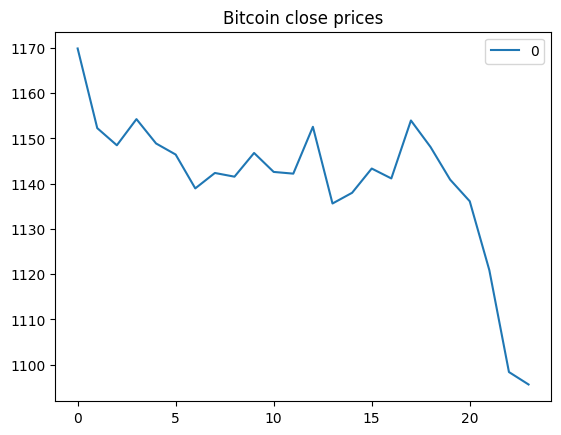

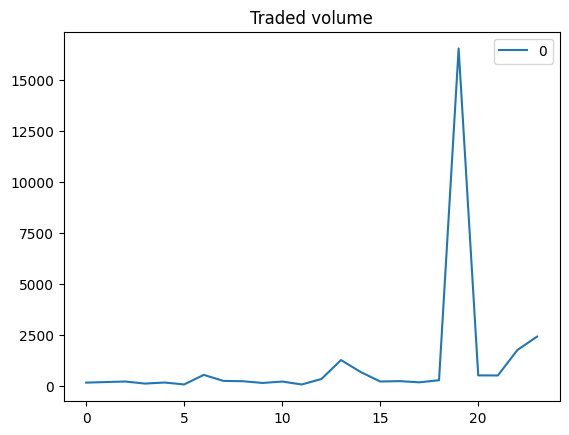

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='Bitcoin close prices')
pd.DataFrame(features[1, 1, :]).plot(title='Traded volume')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
industrial_model =  evaluate_loop(api_params=params, finetune=True)

2024-04-04 15:27:05,531 - Initialising experiment setup
2024-04-04 15:27:05,534 - Initialising Industrial Repository
2024-04-04 15:27:06,157 - Initialising Dask Server
Creating Dask Server
2024-04-04 15:27:07,200 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-04 15:27:07,239 - State start
2024-04-04 15:27:07,993 -   Scheduler at: inproc://10.64.4.217/19992/1
2024-04-04 15:27:07,994 -   dashboard at:  http://10.64.4.217:56751/status
2024-04-04 15:27:07,995 - Registering Worker plugin shuffle
2024-04-04 15:27:08,768 -       Start worker at: inproc://10.64.4.217/19992/4
2024-04-04 15:27:08,769 -          Listening to:          inproc10.64.4.217
2024-04-04 15:27:08,770 -           Worker name:                          0
2024-04-04 15:27:08,771 -          dashboard at:          10.64.4.217:56752
2024-04-04 15:27:08,772 - Waiting to connect to: inproc://10.64.4.217/19992/1
2024-04-04 15:27:08,773 - --------

[I 2024-04-04 15:32:08,825] A new study created in memory with name: no-name-0ddfe81e-f266-4369-a110-2163aef6ecc3


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-04 15:32:13,093] Trial 0 finished with value: 0.23042046756403378 and parameters: {'0 || treg | max_features': 0.3213408727590865, '0 || treg | min_samples_split': 11, '0 || treg | min_samples_leaf': 4, '0 || treg | bootstrap': False}. Best is trial 0 with value: 0.23042046756403378.
[I 2024-04-04 15:32:13,615] Trial 2 finished with value: 0.23682683388440515 and parameters: {'0 || treg | max_features': 0.5250482160048807, '0 || treg | min_samples_split': 6, '0 || treg | min_samples_leaf': 1, '0 || treg | bootstrap': True}. Best is trial 0 with value: 0.23042046756403378.
[I 2024-04-04 15:32:15,222] Trial 1 finished with value: 0.2616077974596068 and parameters: {'0 || treg | max_features': 0.3346514356931707, '0 || treg | min_samples_split': 6, '0 || treg | min_samples_leaf': 17, '0 || treg | bootstrap': False}. Best is trial 0 with value: 0.23042046756403378.
[I 2024-04-04 15:32:15,346] Trial 3 finished with value: 0.2613298911824887 and parameters: {'0 || treg | max_featu

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [10]:
labels = industrial_model.predict(test_data)
metrics = industrial_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [11]:
metrics

,r2,rmse,mae
0,0.264,0.23,0.175


## AutoML approach

In [12]:
industrial_auto_model = evaluate_loop(api_params=params, finetune=False)

2024-04-04 15:38:02,621 - Initialising experiment setup
2024-04-04 15:38:02,624 - Initialising Industrial Repository
2024-04-04 15:38:02,625 - Initialising Dask Server
Creating Dask Server
2024-04-04 15:38:02,649 - State start
2024-04-04 15:38:03,398 -   Scheduler at: inproc://10.64.4.217/19992/9
2024-04-04 15:38:03,400 -   dashboard at:  http://10.64.4.217:57064/status
2024-04-04 15:38:03,401 - Registering Worker plugin shuffle
2024-04-04 15:38:04,167 -       Start worker at: inproc://10.64.4.217/19992/12
2024-04-04 15:38:04,169 -          Listening to:          inproc10.64.4.217
2024-04-04 15:38:04,170 -           Worker name:                          0
2024-04-04 15:38:04,171 -          dashboard at:          10.64.4.217:57067
2024-04-04 15:38:04,171 - Waiting to connect to: inproc://10.64.4.217/19992/9
2024-04-04 15:38:04,172 - -------------------------------------------------
2024-04-04 15:38:04,173 -               Threads:                          8
2024-04-04 15:38:04,174 -     

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-04 15:38:05,771 - IndustrialDispatcher - Number of used CPU's: 2
2024-04-04 15:38:15,539 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-04 15:38:15,581 - IndustrialEvoOptimizer - Generation num: 1 size: 1
2024-04-04 15:38:15,584 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.261 node_number=0.200>']
2024-04-04 15:38:17,160 - IndustrialDispatcher - Number of used CPU's: 2
2024-04-04 15:42:27,247 - IndustrialDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2024-04-04 15:42:27,367 - IndustrialEvoOptimizer - Generation num: 2 size: 21
2024-04-04 15:42:27,369 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.231 node_number=0.300>']
2024-04-04 15:42:27,371 - IndustrialEvoOptimizer - Next population size: 21; max graph depth: 6
2024-04-04 15:42:45,478 - IndustrialDispatcher - Number of used CPU's: 2
2024-04-

Generations:   0%|          | 1/10000 [10:46<1795:39:09, 646.50s/gen]

2024-04-04 15:48:52,363 - IndustrialEvoOptimizer - Generation num: 3 size: 21
2024-04-04 15:48:52,364 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.231 node_number=0.300>']
2024-04-04 15:48:52,367 - IndustrialEvoOptimizer - no improvements for 1 iterations
2024-04-04 15:48:52,368 - IndustrialEvoOptimizer - spent time: 10.8 min
2024-04-04 15:48:52,369 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [10:46<1795:55:47, 646.60s/gen]

2024-04-04 15:48:52,372 - OptimisationTimer - Composition time: 10.777 min
2024-04-04 15:48:52,377 - OptimisationTimer - Algorithm was terminated due to processing time limit
2024-04-04 15:48:52,384 - IndustrialEvoOptimizer - Generation num: 4 size: 1
2024-04-04 15:48:52,386 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.231 node_number=0.300>']
2024-04-04 15:48:52,388 - IndustrialEvoOptimizer - no improvements for 2 iterations
2024-04-04 15:48:52,390 - IndustrialEvoOptimizer - spent time: 10.8 min
2024-04-04 15:48:52,396 - GPComposer - GP composition finished
2024-04-04 15:48:52,402 - DataSourceSplitter - Stratificated splitting of data is disabled.
2024-04-04 15:48:52,411 - DataSourceSplitter - Hold out validation is applied.
2024-04-04 15:48:52,417 - ApiComposer - Hyperparameters tuning started with 4 min. timeout
2024-04-04 15:48:52,423 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


2024-04-04 15:48:59,047 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [treg, quantile_extractor, normalization]}
treg - {}
quantile_extractor - {}
normalization - {} 
Initial metric: [0.247]
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2024-04-04 15:48:59,079 - build_posterior_wrapper took 0.011013 seconds
2024-04-04 15:48:59,082 - TPE using 0 trials
  0%|          | 1/100000 [00:01<29:37:27,  1.07s/trial, best loss: 0.2436367484624975]2024-04-04 15:49:00,147 - build_posterior_wrapper took 0.010874 seconds
2024-04-04 15:49:00,150 - TPE using 1/1 trials with best loss 0.243637
  0%|          | 2/100000 [00:02<28:56:23,  1.04s/trial, best loss: 0.2436367484624975]2024-04-04 15:49:01,171 - build_posterior_wrapper took 0.009973 seconds
2024-04-04 15:49:01,172 - TPE using 2/2 trials with best loss 0.243637
  0%|          | 3/100000 [00:03<31:49:30,  1.15s/trial, best loss: 0.2436367484624975]2024-04-04 15:49:02,441 - build_posterior_wrapper took 0.0099

In [13]:
auto_labels = industrial_auto_model.predict(test_data)
auto_metrics = industrial_auto_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [14]:
auto_metrics

,r2,rmse,mae
0,0.288,0.226,0.172


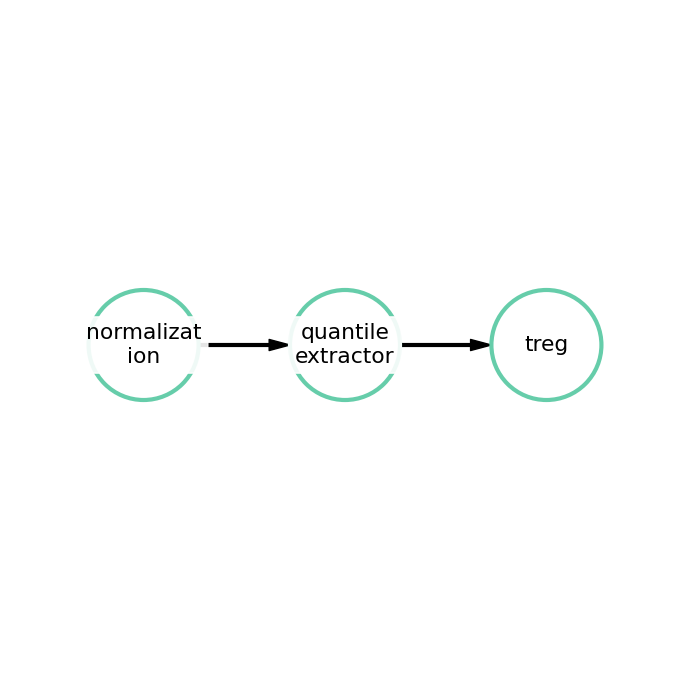

2024-04-04 15:53:47,103 - OperationsAnimatedBar - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 15:53:47,267 - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-04-04 15:53:47,268 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-04-04 15:53:57,302 - OperationsAnimatedBar - The animation was saved to "D:\WORK\Repo\Industiral\IndustrialTS\results_of_experiments\history_animated_bars.gif".
2024-04-04 15:53:57,304 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 15:53:57,336 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-04 15:53:57,342 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the a

In [15]:
industrial_auto_model.solver.current_pipeline.show()
industrial_auto_model.plot_operation_distribution(mode='each')
industrial_auto_model.plot_fitness_by_generation()

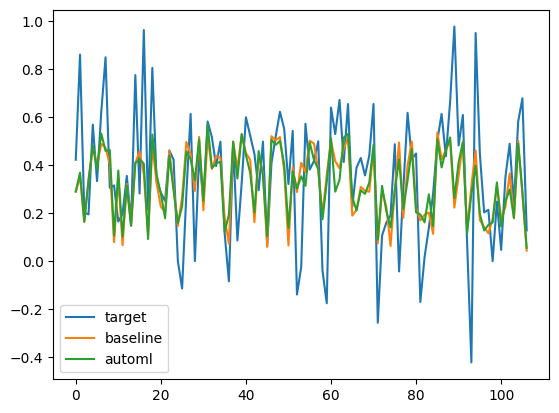

In [16]:
predictions = np.vstack([test_data[1].flatten(),labels.flatten(),auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target','baseline','automl'])
all_prediction.plot()
plt.show()

2024-04-04 17:48:21,275 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 17:48:22,074 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-04 17:48:22,100 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


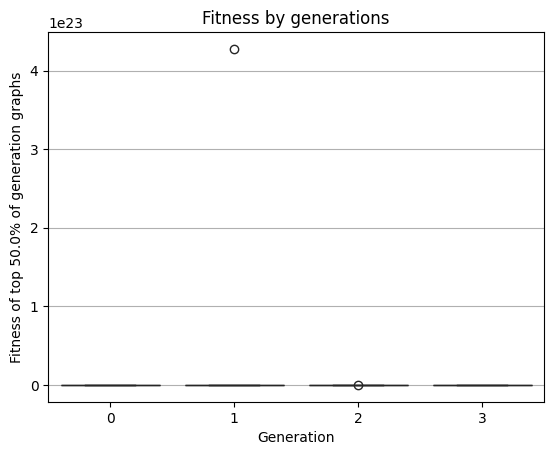

In [22]:
industrial_auto_model.solver.history.show.fitness_box(best_fraction=0.5, dpi=100)

In [23]:
industrial_auto_model.solver.return_report()

,days,hours,minutes,seconds,milliseconds
Data Definition (fit),0,0,0,0,0
Data Preprocessing,0,0,0,0,340
Fitting (summary),0,0,14,55,282
Composing,0,0,10,48,170
Train Inference,0,0,0,1,64
Tuning (composing),0,0,4,5,682
Tuning (after),0,0,0,0,0
Data Definition (predict),0,0,0,0,0
Predicting,0,0,0,0,249


2024-04-04 17:48:37,193 - OperationsKDE - Visualizing optimization history... It may take some time, depending on the history size.


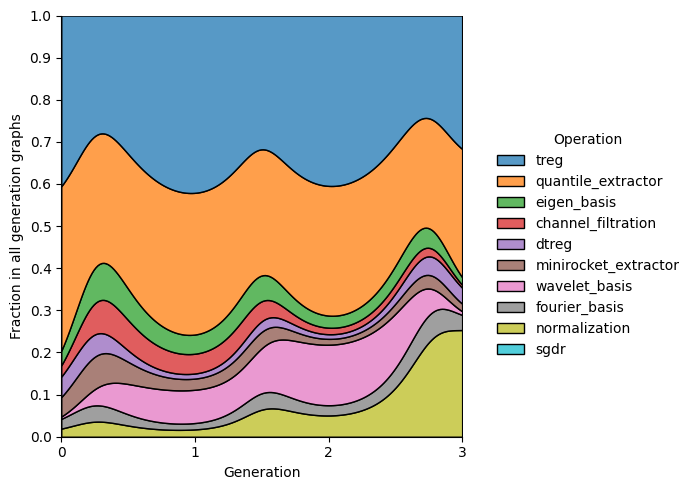

In [24]:
industrial_auto_model.solver.history.show.operations_kde(dpi=100)

## Compare with State of Art (SOTA) models

In [17]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [18]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [19]:
df.sort_values('min')['min']

FreshPRINCE_RMSE           0.180515
DrCIF_RMSE                 0.180643
RotF_RMSE                  0.187496
RandF_RMSE                 0.193914
FPCR_RMSE                  0.195632
TSF_RMSE                   0.200847
FPCR-Bs_RMSE               0.201391
5NN-DTW_RMSE               0.205914
RDST_RMSE                  0.208743
Ridge_RMSE                 0.213185
5NN-ED_RMSE                0.215282
RIST_RMSE                  0.222417
FCN_RMSE                   0.222711
XGBoost_RMSE               0.224208
ResNet_RMSE                0.224795
InceptionT_RMSE            0.224887
MultiROCKET_RMSE           0.224921
Fedot_Industrial_AutoML    0.226000
SingleInception_RMSE       0.226110
Grid-SVR_RMSE              0.227387
Fedot_Industrial_tuned     0.230000
CNN_RMSE                   0.234338
1NN-DTW_RMSE               0.255744
ROCKET_RMSE                0.257576
1NN-ED_RMSE                0.267144
Name: min, dtype: float64

In [20]:
df.sort_values('max')['max']

Fedot_Industrial_AutoML    0.226000
Fedot_Industrial_tuned     0.230000
DrCIF_RMSE                 0.256310
RIST_RMSE                  0.256706
RandF_RMSE                 0.257411
RDST_RMSE                  0.257594
FreshPRINCE_RMSE           0.260502
RotF_RMSE                  0.263084
5NN-ED_RMSE                0.264245
FPCR_RMSE                  0.268228
5NN-DTW_RMSE               0.268344
TSF_RMSE                   0.269265
FPCR-Bs_RMSE               0.276976
XGBoost_RMSE               0.281631
InceptionT_RMSE            0.288174
Grid-SVR_RMSE              0.290551
MultiROCKET_RMSE           0.291900
FCN_RMSE                   0.295570
SingleInception_RMSE       0.296679
ResNet_RMSE                0.302419
Ridge_RMSE                 0.314523
ROCKET_RMSE                0.319622
CNN_RMSE                   0.348164
1NN-ED_RMSE                0.427555
1NN-DTW_RMSE               0.435497
Name: max, dtype: float64

In [21]:
df.sort_values('average')['average']

DrCIF_RMSE                 0.223448
FreshPRINCE_RMSE           0.225876
Fedot_Industrial_AutoML    0.226000
RotF_RMSE                  0.229423
Fedot_Industrial_tuned     0.230000
FPCR_RMSE                  0.231336
RandF_RMSE                 0.233020
TSF_RMSE                   0.234477
FPCR-Bs_RMSE               0.235169
RDST_RMSE                  0.239879
RIST_RMSE                  0.241129
5NN-DTW_RMSE               0.241217
5NN-ED_RMSE                0.246046
MultiROCKET_RMSE           0.249028
InceptionT_RMSE            0.251960
XGBoost_RMSE               0.252351
FCN_RMSE                   0.252702
ResNet_RMSE                0.255854
Grid-SVR_RMSE              0.257539
SingleInception_RMSE       0.257753
Ridge_RMSE                 0.262168
CNN_RMSE                   0.271610
ROCKET_RMSE                0.287077
1NN-DTW_RMSE               0.318791
1NN-ED_RMSE                0.333878
Name: average, dtype: float64